In [170]:
import pandas as pd
import numpy as np
import os
import pickle
import time
import random
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline

# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier

# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [171]:
# Use the GPU
if torch.backends.mps.is_available():
    print("MPS device is available.")
    device = torch.device("mps")
elif torch.cuda.is_available():
    print("CUDA device is available.")
    device = torch.device("cuda")
else:
    print("No GPU acceleration available.")
    device = torch.device("cpu")

# Fix the seed to have deterministic behaviour
def fix_random(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

SEED = 1337
fix_random(SEED)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

DATASET_PATH = "dataset_train/dataset.csv"
dataset = pd.read_csv(DATASET_PATH, delimiter=",")

print(f"Shape of the dataset: {dataset.shape}")
duplicates = dataset[dataset.duplicated()]
print(f"Number of duplicates in the dataset: {duplicates.shape[0]}")

MPS device is available.
Shape of the dataset: (148301, 145)
Number of duplicates in the dataset: 0


Text(0.5, 0, 'Credit Risk Grade')

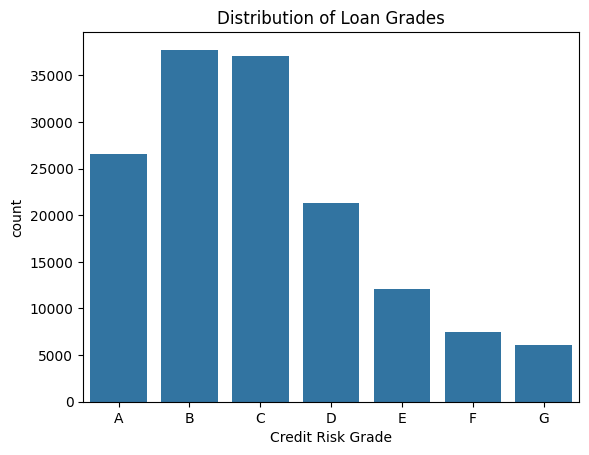

In [172]:
# Get the different types of credit risk, and its distribution
grade_types = sorted(dataset['grade'].unique())

sns.countplot(data=dataset, x='grade', order=grade_types)
plt.title('Distribution of Loan Grades')
plt.xlabel('Credit Risk Grade')

## Handling NaNs

original_projected_additional_accrued_interest       99.564399
hardship_loan_status_label                           99.432910
hardship_type_label                                  99.431561
hardship_end_date                                    99.431561
hardship_duration_days                               99.430887
hardship_last_payment_amount_total                   99.430887
hardship_days_past_due                               99.430887
hardship_reason_label                                99.430213
hardship_start_date                                  99.429539
hardship_payment_plan_start_date                     99.429539
hardship_deferral_term_months                        99.428864
hardship_status_label                                99.428190
hardship_amount_total                                99.428190
hardship_payoff_balance                              99.427516
secondary_applicant_months_since_last_major_derog    98.374927
settlement_term_months                               98

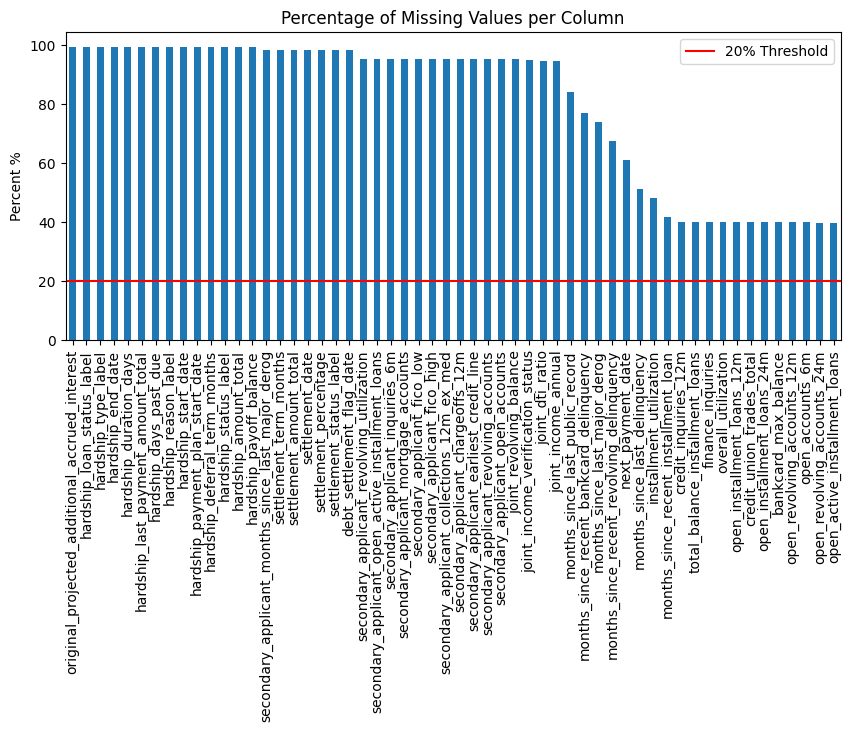

In [ ]:
COLUMNS_TO_DROP_PERCENT = 20 # WHAT IF I PUT 50 INSTEAD?

# Show the percentage of missing values
missing_percentages = dataset.isna().mean() * 100
cols_to_drop = missing_percentages[missing_percentages > COLUMNS_TO_DROP_PERCENT]
print(cols_to_drop.sort_values(ascending=False))

plt.figure(figsize=(10, 4))
cols_to_drop.sort_values(ascending=False).plot(kind='bar')
plt.title('Percentage of Missing Values per Column')
plt.ylabel('Percent %')
plt.axhline(y=COLUMNS_TO_DROP_PERCENT, color='r', linestyle='-', label=f'{COLUMNS_TO_DROP_PERCENT}% Threshold')
plt.legend()
plt.show()

In [174]:
# drop columns with more than 20% of NaNs. We go from 145 to 89 features
print(dataset.shape)
dataset = dataset.drop(columns=cols_to_drop.index)
print(dataset.shape)

(148301, 145)
(148301, 89)


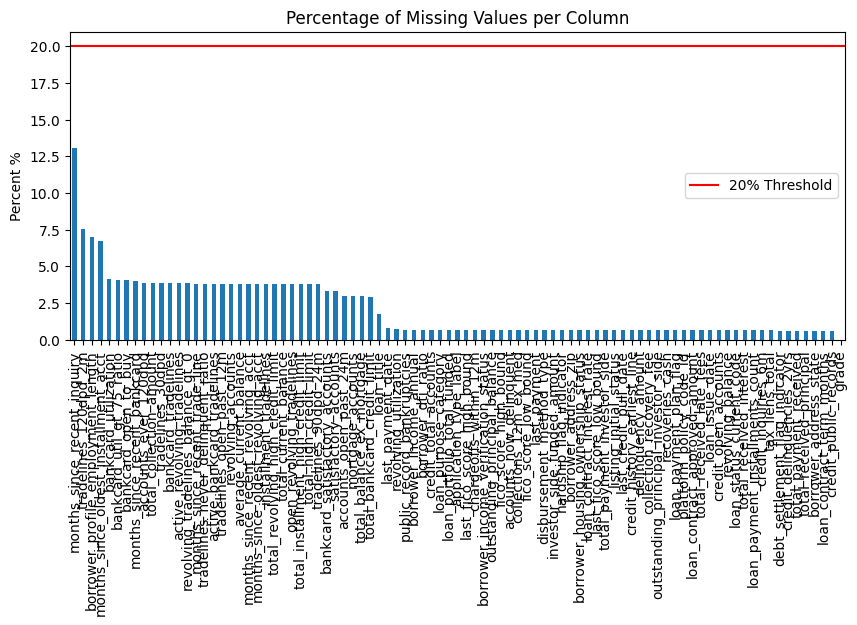

In [175]:
# Show the percentage of missing values
missing_percentages = dataset.isna().mean() * 100
plt.figure(figsize=(10, 4))
missing_percentages.sort_values(ascending=False).plot(kind='bar')
plt.title('Percentage of Missing Values per Column')
plt.ylabel('Percent %')
plt.axhline(y=COLUMNS_TO_DROP_PERCENT, color='r', linestyle='-', label=f'{COLUMNS_TO_DROP_PERCENT}% Threshold')
plt.legend()
plt.show()

## Handling the remaining data
For the column with more than 10% of missing data we try to save it with a flag. we remove all the other rows with missing data since they amount at maximum to 7.5% of our dataset

In [ ]:
print(dataset.shape)
print(dataset["grade"].isna().sum())

# =============
# TODO: CHECK THIS BECAUSE WE DON'T COPY DF FIlLED BACK INTO DATASET
# ===============

from scipy.stats import normaltest
# 1. Define the filling function with safeguards
def sophisticated_imputation(group):
    # Remove NaNs to run the test
    clean_data = group.dropna()

    # 'normaltest' requires at least 8 samples to work correctly
    if len(clean_data) < 8:
        # Not enough data to test distribution; default to median (safer)
        return group.fillna(group.median())

    # Run the test
    stat, p_value = normaltest(clean_data)

    # 2. Logic: High p-value (e.g., > 0.05) means we cannot reject normality
    if p_value > 0.05:
        return group.fillna(group.mean())
    else:
        return group.fillna(group.median())

# Create a copy to avoid SettingWithCopy warnings
df_filled = dataset.copy()

# 3. Identify columns: Numeric columns that actually have missing data
numeric_cols = df_filled.select_dtypes(include="number").columns
cols_with_nans = [col for col in numeric_cols if df_filled[col].isnull().any()]

# 4. Iterate and Apply
for col in cols_with_nans:
    if col == 'grade': continue  # Skip the grouping column itself
    
    # Apply the transformation
    df_filled[col] = df_filled.groupby('grade')[col].transform(sophisticated_imputation)

dataset = df_filled

print(f"Imputation complete for columns: {cols_with_nans}")
print(dataset.shape)
print(dataset["grade"].isna().sum())

# def group_fill(group):
#     # Check distribution of this specific group
#     clean_data = group.dropna()
        
#     stat, p_value = normaltest(clean_data)
    
#     if p_value > 0.05:
#         # Normal for this class
#         print("normal")
#         return group.fillna(group.mean())
#     else:
#         # Skewed for this class
#         print("skewed")
#         return group.fillna(group.median())

# # Apply using groupby and transform
# df_filled_group = dataset.copy()

# df_filled_group['months_since_recent_inquiry'] = dataset.groupby('grade')['months_since_recent_inquiry'].transform(group_fill)

# print("Group-wise filling complete.")

# from sklearn.experimental import enable_iterative_imputer  # Explicitly enable experimental feature
# from sklearn.impute import IterativeImputer
# from sklearn.linear_model import BayesianRidge

# # Select only numerical columns for regression
# features = ['months_since_recent_inquiry']

# # Initialize the imputer
# # You can change the estimator (e.g., DecisionTreeRegressor, BayesianRidge, etc.)
# imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=50)

# # Fit and transform
# # Note: It returns a numpy array, so we put it back into a DataFrame
# imputed_values = imputer.fit_transform(dataset[features])

# df_filled_model = dataset.copy()
# df_filled_model[features] = imputed_values

# print("Model-based filling complete.")

(148301, 89)
0
Imputation complete for columns: ['loan_contract_approved_amount', 'loan_portfolio_total_funded', 'investor_side_funded_amount', 'loan_contract_interest_rate', 'loan_payment_installments_count', 'borrower_income_annual', 'borrower_dti_ratio', 'credit_delinquencies_2yrs', 'fico_score_low_bound', 'fico_score_high_bound', 'credit_inquiries_6m', 'credit_open_accounts', 'credit_public_records', 'revolving_balance', 'revolving_utilization', 'credit_total_accounts', 'outstanding_principal_balance', 'outstanding_principal_investor_side', 'total_payment_received', 'total_payment_investor_side', 'total_received_principal', 'total_received_interest', 'total_received_late_fees', 'recoveries_cash', 'collection_recovery_fee', 'last_payment', 'last_fico_score_high_bound', 'last_fico_score_low_bound', 'collections_12m_ex_med', 'platform_policy_code_id', 'accounts_now_delinquent', 'total_collection_amount', 'total_current_balance', 'total_revolving_high_credit_limit', 'accounts_open_past

In [ ]:
missing_counts = dataset.isnull().sum()
print(missing_counts[missing_counts > 0.sort_values(ascending=False)])

loan_contract_approved_amount             942
loan_portfolio_total_funded               991
investor_side_funded_amount               961
loan_contract_term_months                 890
loan_contract_interest_rate               957
loan_payment_installments_count           927
borrower_profile_employment_length      10356
borrower_housing_ownership_status         959
borrower_income_annual                   1016
borrower_income_verification_status       980
loan_issue_date                           938
loan_status_current_code                  933
loan_payment_plan_flag                    949
loan_purpose_category                     991
loan_title                               2578
borrower_address_zip                      959
borrower_address_state                    895
borrower_dti_ratio                       1011
credit_delinquencies_2yrs                 917
credit_history_earliest_line              952
fico_score_low_bound                      976
fico_score_high_bound             

In [178]:
print(missing_counts["total_bankcard_credit_limit"])

4363


In [179]:
dataset['total_bankcard_credit_limit'] = dataset['total_bankcard_credit_limit'].fillna(
    dataset.groupby('grade')['total_bankcard_credit_limit'].transform('median')
)

In [180]:
missing_counts = dataset.isnull().sum()
print(missing_counts["total_bankcard_credit_limit"])

0


In [181]:
print(dataset["borrower_profile_employment_length"].isnull().sum())

10356


# TODO Data cleaning
• Use a measure like the mean (or median) to fill in the missing values:
• for normal (symmetric) data distributions => mean
• for skewed data distribution => median

• Use the feature mean or median for all samples belonging to the same class as the given
observation
• If the data distribution for a given class is skewed=> median
• For normal distributions?

• Use the most probable value to fill in the missing value:
• Regression, decision tree, etc...

In [182]:
print(dataset.shape)

(148301, 89)


In [183]:
# # 1. Create a flag column: 1 if missing, 0 if present
# dataset["missing_inquiry_flag"] = dataset["months_since_recent_inquiry"].isna().astype(int)

# # 2. Fill the original column with the Median (neutral value)
# median_val = dataset["months_since_recent_inquiry"].median()
# dataset["months_since_recent_inquiry"] = dataset["months_since_recent_inquiry"].fillna(median_val)
# dataset= dataset.drop(columns="months_since_recent_inquiry")

In [184]:
# DROP NAN FEATURES
print(dataset.shape)
print(dataset["grade"].isna().sum())
dataset=dataset.dropna()
print(dataset.shape)
print(dataset["grade"].isna().sum())

(148301, 89)
0
(62909, 89)
0


# Handling categorical data
We convert categorical data to float values for data processing

In [ ]:
# Stateless transformations (can be done on train and test set independently)
dataset["grade"] = dataset["grade"].map({'A': 6, 'B': 5, 'C': 4, 'D': 3, 'E': 2, 'F': 1, 'G': 0})

def extract_int_value_from_column(column_name):
    dataset[column_name] = dataset[column_name].str.extract(r"(\d+)").astype(int)

def convert_mm_yyyy_to_year_sine_cosine(column_name):
    # Convert mm-yyyy to the year and month encoded in sine/cosine representation so that dec 1999 and jan 2000 are close
    dataset[column_name] = pd.to_datetime(dataset[column_name], format='%b-%Y')
    date_col = dataset[column_name].dt # avoid creating temporary object
    dataset[f"{column_name}_year"] = date_col.year
    angle = 2 * np.pi * date_col.month / 12
    dataset[f"{column_name}_month_sin"] = np.sin(angle)
    dataset[f"{column_name}_month_cos"] = np.cos(angle)
    dataset.drop(columns=[column_name], inplace=True)

extract_int_value_from_column("loan_contract_term_months")
extract_int_value_from_column("borrower_profile_employment_length")

convert_mm_yyyy_to_year_sine_cosine("loan_issue_date")
convert_mm_yyyy_to_year_sine_cosine("credit_history_earliest_line")
convert_mm_yyyy_to_year_sine_cosine("last_payment_date")
convert_mm_yyyy_to_year_sine_cosine("last_credit_pull_date")

In [ ]:
# Stateful transformations (with statistics calculated on training set and applied on both sets)

In [ ]:

# STATEFUL TRANSFORMATIONS

def convert_binary_categorical_column_to_numerical(column_name):
    majority_code = dataset[column_name].mode()[0]
    dataset[column_name] = (dataset[column_name] == majority_code).astype(int)



convert_binary_categorical_column_to_numerical("loan_payment_plan_flag")
convert_binary_categorical_column_to_numerical("listing_initial_status")
convert_binary_categorical_column_to_numerical("application_type_label")
convert_binary_categorical_column_to_numerical("hardship_flag_indicator")
convert_binary_categorical_column_to_numerical("disbursement_method_type")
convert_binary_categorical_column_to_numerical("debt_settlement_flag_indicator")


def one_hot_encode_column(df, column_name):
    encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    encoded_data = encoder.fit_transform(df[[column_name]])
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out([column_name]), index=df.index)
    return pd.concat([df, encoded_df], axis=1).drop(columns=[column_name])

# to one-hot encode 
# CORRECT WAY: Re-assign 'dataset' each time
dataset = one_hot_encode_column(dataset, "borrower_housing_ownership_status")
dataset = one_hot_encode_column(dataset, "borrower_income_verification_status")
dataset = one_hot_encode_column(dataset, "loan_status_current_code")
dataset = one_hot_encode_column(dataset, "loan_purpose_category")
dataset.drop(columns="loan_title", inplace=True) # redundant with loan_purpose_category
dataset = one_hot_encode_column(dataset, "borrower_address_state")

print(dataset.shape)
# to embed (ONLY IN TEST SET)
# borrower_address_zip 
print("-"*50)

categorical_cols = dataset.select_dtypes(include=['object', 'category']).columns
print(categorical_cols.shape)
print(categorical_cols)

for col in categorical_cols:
    print(f"{col}: {dataset[col].nunique()} unique values")
    print(f"{dataset[col].unique()}")
    print("---")

(62909, 89)
Unique grades: ['D' 'C' 'A' 'B' 'G' 'E' 'F']
Unique grades: [3 4 6 5 0 2 1]
(62909, 165)
--------------------------------------------------
(1,)
Index(['borrower_address_zip'], dtype='object')
borrower_address_zip: 872 unique values
['109xx' '152xx' '921xx' '018xx' '272xx' '530xx' '144xx' '553xx' '267xx'
 '391xx' '951xx' '200xx' '221xx' '601xx' '755xx' '334xx' '116xx' '105xx'
 '770xx' '666xx' '412xx' '066xx' '762xx' '907xx' '981xx' '217xx' '350xx'
 '235xx' '386xx' '210xx' '970xx' '807xx' '933xx' '016xx' '871xx' '115xx'
 '940xx' '911xx' '800xx' '450xx' '956xx' '026xx' '972xx' '474xx' '148xx'
 '891xx' '731xx' '946xx' '296xx' '462xx' '926xx' '606xx' '925xx' '840xx'
 '111xx' '234xx' '724xx' '322xx' '331xx' '945xx' '303xx' '703xx' '980xx'
 '922xx' '786xx' '039xx' '114xx' '604xx' '451xx' '563xx' '605xx' '850xx'
 '076xx' '042xx' '325xx' '212xx' '255xx' '722xx' '906xx' '067xx' '700xx'
 '112xx' '852xx' '902xx' '930xx' '992xx' '341xx' '721xx' '490xx' '275xx'
 '914xx' '662xx' '121xx' 

In [186]:
# 1. Label Encode the Zip Codes (Convert '902xx' -> 0, '100xx' -> 1...)
# This creates the inputs for the Embedding Layer
zip_codes = dataset['borrower_address_zip'].astype('category').cat.codes.values
# Convert to PyTorch Tensor
zip_tensor = torch.tensor(zip_codes, dtype=torch.long)

# 2. Define the Embedding Layer
num_unique_zips = len(dataset['borrower_address_zip'].unique()) # 876
embedding_dim = 15 # Compress 876 values into a vector of size 15

# This layer is a lookup table that will be trained
zip_embedding_layer = nn.Embedding(num_embeddings=num_unique_zips, embedding_dim=embedding_dim)

# 3. Forward Pass (simulated)
# In your actual training loop, this happens automatically
vectors = zip_embedding_layer(zip_tensor) 

print(vectors.shape) 
# Output: (N_rows, 15) <- You now have 15 numerical columns instead of 876

# 1. Extract weights from PyTorch
# We use .detach() to remove gradients and .numpy() to convert to a standard array
weights = zip_embedding_layer.weight.detach().numpy() 

# 2. Ensure your dataset has the integer encoded column
# (You created 'zip_codes' in step 1, make sure it's in the dataframe)
dataset['zip_code_encoded'] = zip_codes

# 3. Create the DataFrame of vectors
# OPTIMIZATION: Instead of using .map() which is slow, we can just use 
# numpy indexing. It acts like a lookup automatically!
embedding_vectors = weights[dataset['zip_code_encoded'].values]

# 4. Create the new DataFrame
zip_df = pd.DataFrame(embedding_vectors, index=dataset.index)
zip_df.columns = [f'zip_embed_{x}' for x in range(embedding_dim)]

# 5. Concatenate with your original data
df_final = pd.concat([dataset, zip_df], axis=1)

# Now drop the original zip columns
dataset = df_final.drop(['borrower_address_zip', 'zip_code_encoded'], axis=1)

print(dataset.columns)

torch.Size([62909, 15])
Index(['loan_contract_approved_amount', 'loan_portfolio_total_funded',
       'investor_side_funded_amount', 'loan_contract_term_months',
       'loan_contract_interest_rate', 'loan_payment_installments_count',
       'borrower_profile_employment_length', 'borrower_income_annual',
       'loan_payment_plan_flag', 'borrower_dti_ratio',
       ...
       'zip_embed_5', 'zip_embed_6', 'zip_embed_7', 'zip_embed_8',
       'zip_embed_9', 'zip_embed_10', 'zip_embed_11', 'zip_embed_12',
       'zip_embed_13', 'zip_embed_14'],
      dtype='object', length=179)


In [187]:
categorical_cols = dataset.select_dtypes(include=['object', 'category']).columns
print(categorical_cols.shape)
print(categorical_cols)

for col in categorical_cols:
    print(f"{col}: {dataset[col].nunique()} unique values")
    print(f"{dataset[col].unique()}")
    print("---")

(0,)
Index([], dtype='object')


By analyzing the dataset we get that:

- `loan_contract_term_months`: has the values 36 and 60 months so we can remove the text and transform to int
- `borrower_profile_employment_length`: has ordinal variables so we can remove the text and transform to int
- `borrower_housing_ownership_status` has 6 values. they could be encoded by "strength" of the status. owning is better than mortgage which is better than rent, but there are also any, other and none which cannot be really comprehended.
- `borrower_income_verification_status`: 3 unique values, can be one-hot encoded.
- `loan_issue_date`: 77 values, can be encoded by extracting the year and calculating a sine/cosine representation for the month. 
- `loan_status_current_code`: 7 unique values, can be one-hot encoded
- `loan_paylment_plan_flag`: 2 values, can be encoded to 0 and 1.
- `loan_purpose_category`: 13 values, can be one-hot encoded.
- `loan_title` is redundant with loan_purpose_category. we keep just the second one because the cardinality is lower.
- `borrower_address_zip`: 876 unique values, can be encoded with embeddings. Zip codes contain geographic correlations (rich areas vs poor areas) that embeddings will learn perfectly.
- `borrower_address_state`: 50 unique values, can be encoded with embeddings.
- `credit_history_earliest_line`: 613 unique values, encoded by extracting the year and calculating a sine/cosine representation for the month.
- `listing_initial_status`: 2 values, can be encoded to 0 and 1
- `last_payment_date`: 78 unique values, encoded by extracting the year and calculating a sine/cosine representation for the month. 
- `application_type_label`: 2 values, can be encoded to 0 and 1
- `hardship_flag_indicator`: 2 values, can be encoded to 0 and 1
- `disbursement_method_type`: 2 values, can be encoded to 0 and 1
- `debt_settlement_flag_indicator`: 2 values, can be encoded to 0 and 1

# Logistic regression

In [188]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

X = dataset.loc[:, dataset.columns != "grade"]
y = dataset["grade"]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

(62909, 178)
(62909,)


# Try decision trees

In [ ]:
# clf = DecisionTreeClassifier(criterion='gini', max_depth=50, random_state=42)
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=50)
clf.fit(X_train, y_train)

# 6. Make Predictions
y_pred = clf.predict(X_test)

# 7. Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9527896995708155

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       559
           1       0.89      0.91      0.90       703
           2       0.90      0.92      0.91      1040
           3       0.94      0.95      0.94      1803
           4       0.97      0.95      0.96      3143
           5       0.96      0.97      0.96      3140
           6       0.98      0.98      0.98      2194

    accuracy                           0.95     12582
   macro avg       0.94      0.94      0.94     12582
weighted avg       0.95      0.95      0.95     12582



In [191]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

y_pred_knn = neigh.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))

Accuracy: 0.23954856143697345

Classification Report:
               precision    recall  f1-score   support

           0       0.10      0.17      0.13       559
           1       0.13      0.19      0.15       703
           2       0.11      0.16      0.13      1040
           3       0.17      0.21      0.19      1803
           4       0.27      0.27      0.27      3143
           5       0.30      0.23      0.26      3140
           6       0.44      0.31      0.36      2194

    accuracy                           0.24     12582
   macro avg       0.22      0.22      0.21     12582
weighted avg       0.27      0.24      0.25     12582



In [141]:
class FinancialDataset(Dataset):
    def __init__(self, X, y):
        # 1. Handle Pandas DataFrame/Series for X
        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.values
            
        # 2. Handle Pandas Series for y
        if isinstance(y, pd.Series):
            y = y.values
            
        # 3. Create tensors (Unconditionally!)
        # ensure floats for features, longs for labels
        self.X = torch.FloatTensor(X) 
        self.y = torch.LongTensor(y)

        self.num_features = X.shape[1]
        self.num_classes = len(np.unique(y))

        
    def __len__(self):
        # This is where your error came from - self.X must exist
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [142]:
class FeedForwardV1(nn.Module):
    def __init__(self, input_size, num_classes, hidden_size):
        super(FeedForwardV1, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.input_layer = nn.Linear(self.input_size, self.hidden_size)
        
        self.output_layer = nn.Linear(self.hidden_size, num_classes)
        
        self.relu = nn.ReLU()
        

    def forward(self, x):
        h = self.input_layer(x)
        h = self.relu(h)
        output = self.output_layer(h)
        return output

# class FeedForwardV1(nn.Module):
#     def __init__(self, input_size, num_classes, hidden_size, depth=1):
#         super(FeedForwardV1, self).__init__()
        
#         model = [
#             nn.Linear(input_size, hidden_size),
#             nn.BatchNorm1d(hidden_size),
#             nn.ReLU()
#         ]

#         block = [
#             nn.Linear(hidden_size, hidden_size),
#             nn.BatchNorm1d(hidden_size),
#             nn.ReLU()
#         ]

#         for i in range(depth):
#             model += block
            
#         self.model = nn.Sequential(*model)
        
#         self.output = nn.Linear(hidden_size, num_classes)

#     def forward(self, x):
#         h = self.model(x)
#         out = self.output(h)
#         return out


In [143]:
def test_model(model, data_loader, device):
    model.eval()
    y_pred = []
    y_test = []
    
    for data, targets in data_loader:
        data, targets = data.to(device), targets.to(device)
        y_pred += model(data)
        y_test += targets
    
    y_test = torch.stack(y_test).squeeze()
    y_pred = torch.stack(y_pred).squeeze()
    y_pred_c = y_pred.argmax(dim=1, keepdim=True).squeeze()
    
    return y_test, y_pred_c, y_pred

In [144]:
# Define a function for the training process

def train_model(model, criterion, optimizer, epoch, scheduler, train_loader, val_loader, device, writer, log_name="best_model"):
    n_iter = 0
    best_valid_loss = float('inf')
    for ep in range(epoch):
        model.train()
        
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)  # why here?
            
            optimizer.zero_grad()

            # Forward pass
            y_pred = model(data)

            # Compute Loss
            loss = criterion(y_pred, targets)
            writer.add_scalar("Loss/train", loss, n_iter)

            # Backward pass
            loss.backward()
            optimizer.step()

            n_iter += 1
        
        labels, _, y_pred = test_model(model, val_loader, device)
        loss_val = criterion(y_pred, labels)
        writer.add_scalar("Loss/val", loss_val, ep)
        
        # save best model
        if loss_val.item() < best_valid_loss:
            best_valid_loss = loss_val.item()
            if not os.path.exists('models'):
                os.makedirs('models')
            torch.save(model.state_dict(), 'models/'+log_name)
        
        writer.add_scalar("Learning Rate", scheduler.get_last_lr()[0], ep)
        
        scheduler.step()
            
    return model

In [145]:
print(X_train.shape[0])
print(X_test.shape[0])

# Scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create the dataset
train_subset = FinancialDataset(X_train,y_train)
test_subset = FinancialDataset(X_test,y_test)

50327
12582


In [146]:
# hyperparameters
num_epochs = 10
learning_rate = 0.01
gamma = 0.5
step_size = 20 
batch_size = 16
hidden_size = 8

In [147]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir="runs/FeedForwardV1")

# Create relative dataloaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)


# Define the architecture, loss and optimizer
model = FeedForwardV1(train_subset.num_features, train_subset.num_classes, hidden_size)
model.to(device)
criterion = torch.nn.CrossEntropyLoss() # non va spostata in GPU perche' viene calcolata su ciascun elemento del batch e non ha iperparametri
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)


# Test before the training
y_test, y_pred_r, _ = test_model(model, test_loader, device)
acc = (y_test == y_pred_r).float().sum() / y_test.shape[0]
print("Accuracy before training:", acc.cpu().numpy())

# Train the model 
model = train_model(model, criterion, optimizer, num_epochs, scheduler, train_loader, test_loader, device, writer)

# Load best model
model.load_state_dict(torch.load("models/best_model", weights_only=True))
model.to(device)

# Test after the training
y_test, y_pred_r, _ = test_model(model, test_loader, device)
acc = (y_test == y_pred_r).float().sum() / y_test.shape[0]
print("Accuracy after training:", acc.cpu().numpy())

Accuracy before training: 0.04450803


KeyboardInterrupt: 